In [1]:
import gym
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# desc = ["SFFF", "FFFH", "FFFF", "FFFG"]

desc = None

env = gym.make('FrozenLake-v1', desc = desc, map_name = "8x8", is_slippery = False)
size = 8
obs = env.reset()

In [3]:
alpha = 0.5
episodes = 500
discount = 0.75
epsilon = .25

Reached_Gift = []
Time_Steps = []

n_s = [3, 5, 7]
alpha_s = [0.25, 0.5, 0.75]

for n in n_s:
    for alpha in alpha_s:
        
        Q_SA = {}
        for s in range(size**2):
            Q_SA[s] = {}
            for a in range(4):
                Q_SA[s][a] = 5

        Pi = {}
        for s in range(size**2):
            Pi[s] = np.random.randint(0, 4)

        ts = [0]
        rg = []

        for e in range(episodes):

            obs = env.reset()

            S = [obs]
            R = [0]

            if np.random.rand() < epsilon:
                A = [np.random.randint(0, 4)]
            else:
                A = [Pi[obs]]

            T = 1e6
            t = 0

            while True:

                if t < T:
                    
                    obs, reward, done, info = env.step(A[t])
                    
                    S.append(obs)
                    R.append(reward)

                    if done:
                        T = t + 1
                    else:
                        if np.random.rand() < epsilon:
                            A.append(np.random.randint(0, 4))
                        else:
                            A.append(Pi[S[t+1]])

                tow = t - n + 1

                if tow >= 0:
                    G = sum([(discount ** (i - tow - 1)) * R[i] for i in range(int(tow+1), int(min(tow + n + 1, T + 1)))])

                    if tow + n < T:
                        G += (discount ** n) * Q_SA[S[tow + n]][A[tow + n]]

                    Q_SA[S[tow]][A[tow]] += alpha * (G - Q_SA[S[tow]][A[tow]])

                    Pi[S[tow]] = np.argmax([Q_SA[S[tow]][0], Q_SA[S[tow]][1], Q_SA[S[tow]][2], Q_SA[S[tow]][3]])

                t += 1

                if tow == T - 1:
                    break

            if sum(R) > 0:
                # If reached gift, decrease learning rate and epsilon
                alpha = alpha * 0.95
                epsilon = epsilon * 0.95
                rg.append(1)
            else:
                rg.append(0)
            
            ts.append(len(R) - 1)
        
        Time_Steps.append(ts[1:])
        Reached_Gift.append(rg)

In [4]:
s = 0
arrows = ['←', '↓', '→', '↑']


for r in range(size):
    for c in range(size):
        print(arrows[Pi[s]], end = " ")
        s += 1
    
    print()


→ → → → → ↓ ← ← 
→ ↑ → → ↓ → ↓ → 
↓ → ← ← ↓ ↓ → ↓ 
← ↑ ↓ ↓ ↓ ↑ → ↓ 
← ↓ → → ↓ ↑ ← ↓ 
↓ ↑ ↓ ← ↓ ↓ ↓ ↓ 
→ ← ← ↓ ↓ → ↑ ↓ 
→ ← ↑ ← ↑ ↑ ← ← 


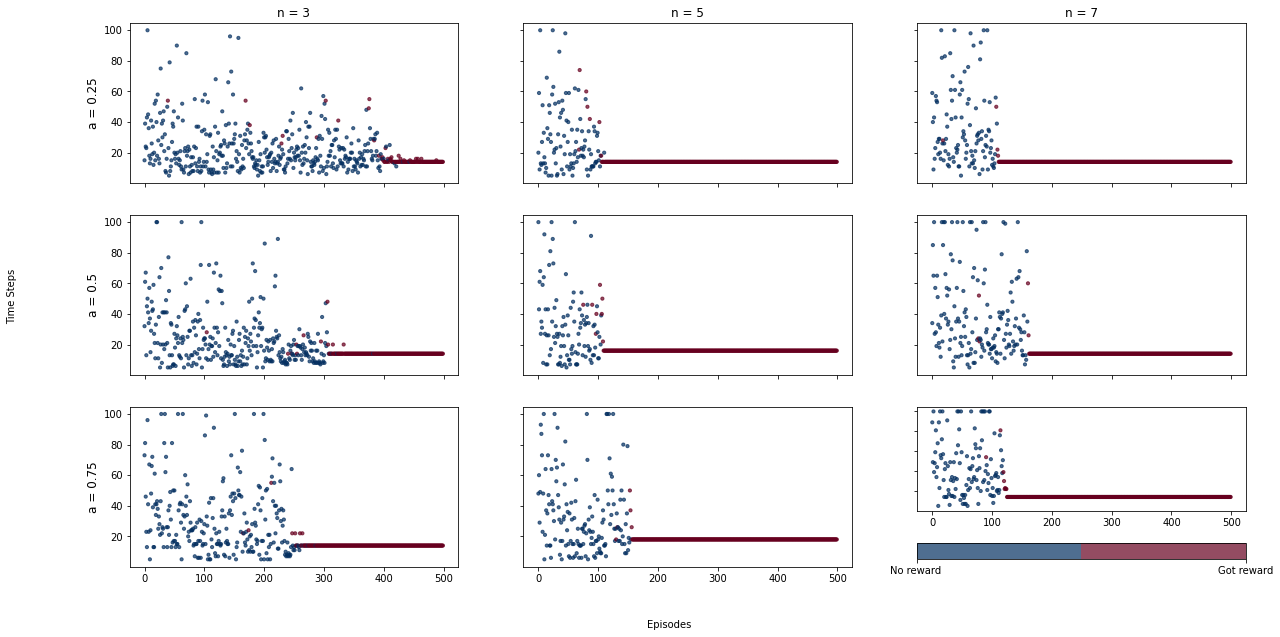

In [5]:
y_axis = [i for i in range(episodes)]

fig, axes = plt.subplots(nrows = 3, ncols = 3, sharex = True, sharey = True, figsize = (20, 10))

col_names = ['n = ' + str(n) for n in n_s]
row_names = ['a = ' + str(alpha) for alpha in alpha_s]

plot_no = 0
for row in axes:
    for col in row:
        im = col.scatter(y_axis, Time_Steps[plot_no], c = Reached_Gift[plot_no], s = 10, 
        cmap=plt.cm.get_cmap('RdBu_r', 2), alpha = 0.7)
        plot_no += 1

fig.text(0.5, 0.04, 'Episodes', ha='center')
fig.text(0.04, 0.5, 'Time Steps', va='center', rotation='vertical')

for ax, col in zip(axes[0], col_names):
    ax.set_title(col)

for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, size='large')


formatter = plt.FuncFormatter(lambda val, loc: np.array(['No reward :(', 'Got reward :)'], dtype='<U10')[val])
fig.colorbar(im, ticks=[0, 1], format = formatter, orientation="horizontal", pad=0.2)

plt.show()